In [ ]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import os
from os.path import join as oj
import sys
sys.path.append('../src')
import numpy as np
import seaborn as sns
import torch
from matplotlib import pyplot as plt
from sklearn import metrics
from sklearn.linear_model import RidgeCV
from sklearn.model_selection import train_test_split
plt.style.use('dark_background')
import data
from skorch.callbacks import Checkpoint
from skorch import NeuralNetRegressor
from config import *
from tqdm import tqdm
import pickle as pkl
import train_reg
from copy import deepcopy
import config
import models
import pandas as pd
import features
from scipy.stats import skew, pearsonr
import outcomes
import neural_networks
import load_tracking
from sklearn.model_selection import KFold
from torch import nn, optim
from torch.nn import functional as F
from tqdm import tqdm

In [ ]:
dsets = ['clath_aux+gak_a7d2', 'clath_aux+gak', 'clath_aux+gak_a7d2_new', 'clath_aux+gak_new', 'clath_gak']
splits = ['train', 'test']
#feat_names = ['X_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
              #['mean_total_displacement', 'mean_square_displacement', 'lifetime']
meta = ['cell_num', 'Y_sig_mean', 'Y_sig_mean_normalized']
dfs = {}
length = 40
for dset in tqdm(dsets):
    
    # load videos, only need to run once
    df = data.get_data(dset=dset, use_processed=False, video_data=True)
    
    # remove invalid tracks
    df = df[~(df.short | df.long | df.hotspots)]
    df = df[df.lifetime > 15]
    
    feat_names = ['X_video_same_length_normalized'] + data.select_final_feats(data.get_feature_names(df))
    
    # downsample tracks
    df['X_video_same_length'] = [features.downsample_video(df.iloc[i]['X_video'], length=length)
                               for i in range(len(df))]
    # normalize tracks
    df = features.normalize_video(df, video='X_video_same_length')

    # regression response
    df = train_reg.add_sig_mean(df)  
    
    # normalize features
    for feat in feat_names:
        if 'video' not in feat and 'X_same_length' not in feat:
            df = features.normalize_feature(df, feat)
    for split in splits:
#         df = df[df.valid]
#         df = df[df.lifetime > 15] # only keep hard tracks

        dfs[(dset, split)] = deepcopy(df[df.cell_num.isin(config.DSETS[dset][split])]) # exclude held-out test data

In [27]:
np.array([df['X_video_same_length_normalized'].iloc[i].shape == (40, 10, 10) for i in range(len(df))]).all()

True

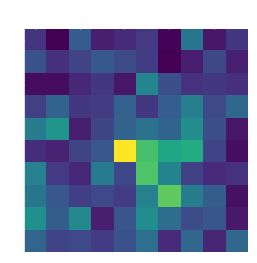

In [74]:
plt.matshow(dfs[(dsets[2], 'train')]['X_video'].iloc[0][0])